# BS-data and SP500 ESG List

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read BS Data

In [2]:
bs_data = pd.read_csv("../data/sacerdote/bs_data.csv")
bs_data

,ticker,permno,siccd,evtdate,sell,buy,amount,amountE,firstname,lastname,...,govtrack_id,icpsr_id,votesmart_id,id,date_of_birth,district,congress,party,seniority,frequent_trader
0,CBNK,91397.0,6036.0,2012-01-03,1.0,0.0,250k+,750000.5,Richard,Hanna,...,NaN,NaN,NaN,NaN,NaN,NY24,112.0,R,NaN,1.0
1,OPY,78451.0,6211.0,2012-01-03,0.0,1.0,100k-249k,175000.5,Brad,Schneider,...,412534.0,21326.0,134948.0,S001190,1961-08-20,10,113.0,D,2.0,1.0
2,STZ,64899.0,2084.0,2012-01-03,1.0,0.0,1k-10k,8000.5,Adam,Schiff,...,400361.0,20104.0,9489.0,S001150,1960-06-22,29,112.0,D,12.0,0.0
3,HON,10145.0,3724.0,2012-01-03,0.0,1.0,1k-10k,8000.5,Alan,Lowenthal,...,412521.0,21313.0,16469.0,L000579,1941-03-08,47,113.0,D,2.0,0.0
4,NUAN,82759.0,7372.0,2012-01-03,1.0,0.0,10k-49k,32500.5,Bill,Owens,...,NaN,NaN,NaN,NaN,NaN,NY23,112.0,D,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50600,BRK.B,NaN,NaN,2020-12-24,0.0,1.0,1k-10k,1000.0,Donald,Beyer,...,412657.0,21554.0,1707.0,B001292,1950-06-20,VA08,114.0,D,2.0,1.0
50601,OHI,77857.0,8062.0,2020-12-31,1.0,0.0,10k-49k,100000.0,Billy,Long,...,412445.0,21150.0,123401.0,L000576,1955-08-11,MO07,112.0,R,2.0,0.0
50602,SO,18411.0,4911.0,2020-12-31,1.0,0.0,1k-10k,50000.0,Billy,Long,...,412445.0,21150.0,123401.0,L000576,1955-08-11,MO07,112.0,R,2.0,0.0
50603,KMI,12558.0,4924.0,2020-12-31,1.0,0.0,50k-99k,50000.0,Billy,Long,...,412445.0,21150.0,123401.0,L000576,1955-08-11,MO07,112.0,R,2.0,0.0


## Read SP 500 and SP ESG data
Source: https://www.barchart.com/stocks/indices/sp/sp500

In [3]:
sp_500 = pd.read_csv("../data/barchart/sp-500.csv")[:-1]
sp_500_list = list(sp_500["Symbol"])

In [4]:
sp_esg = pd.read_csv("../data/barchart/sp-esg.csv")[:-1]
sp_esg_list = list(sp_esg["Symbol"])

In [5]:
# proportion of transactions that are SP500 stocks
bs_data_sp500 = bs_data[bs_data["ticker"].isin(sp_500_list)].copy()
len(bs_data_sp500) / len(bs_data)

0.5624938247208774

In [6]:
# unique politician in bs dataset
len(bs_data["id"].unique())

279

In [7]:
# unique politician in bs-sp500
len(bs_data_sp500["id"].unique())

235

## Generate baseline involvement factor
Again, define ESG "involvement" factor $I_i$: 

$$ I_i = \frac{T^e_i}{T^e_i + T^n_i}$$

where
- $T^e_i$: number of ESG stocks transactions (`esg` = 1)
- $T^n_i$: number of non-ESG stocks transactions (`esg` = 0)

In [8]:
bs_data_sp500["esg"] = bs_data_sp500["ticker"].isin(sp_esg_list).astype(int)

In [9]:
bs_data_sp500_grouped = bs_data_sp500.groupby(["firstname", "lastname", "id", "esg"])[["ticker"]].count()
bs_data_sp500_grouped

ticker
firstname      lastname  id      esg        
"Andy" Garland Barr      B001282 0         1
                                 1         4
Adam           Kinzinger K000378 1         6
               Schiff    S001150 1        18
Alan           Lowenthal L000579 0       102
...                                      ...
William        Timmons   T000480 1        13
William L. Jr  Clay      C001049 0         1
                                 1         3
Zoe            Lofgren   L000397 0        44
                                 1       102

[400 rows x 1 columns]

In [10]:
def involvement_factor(data, pid):
    subset = data[data["id"] == pid]
    esg = subset[subset["esg"] == 1]
    non_esg = subset[subset["esg"] == 0]
    if len(esg) > 0:
        esg_count = esg["ticker"].iloc[0]
    else:
        esg_count = 0
        
    if len(non_esg) > 0:
        non_esg_count = non_esg["ticker"].iloc[0]
    else:
        non_esg_count = 0
    
    return esg_count / (esg_count + non_esg_count)

In [11]:
bs_data_sp500_grouped = bs_data_sp500_grouped.reset_index()

In [12]:
inv_factors = pd.DataFrame({
    "id": bs_data_sp500_grouped["id"].unique(), 
    "inv_factor": list(map(lambda pid: involvement_factor(bs_data_sp500_grouped, pid), bs_data_sp500_grouped["id"].unique()))
})
inv_factors.merge(bs_data_sp500_grouped[["firstname", "lastname", "id"]], how="left", on="id").drop_duplicates()

,id,inv_factor,firstname,lastname
0,B001282,0.800000,"""Andy"" Garland",Barr
2,K000378,1.000000,Adam,Kinzinger
3,S001150,1.000000,Adam,Schiff
4,L000579,0.722071,Alan,Lowenthal
6,S001165,1.000000,Albio,Sires
...,...,...,...,...
391,F000450,0.516340,Virginia,Foxx
393,D000626,1.000000,Warren,Davidson
394,T000480,0.812500,William,Timmons
396,C001049,0.750000,William L. Jr,Clay


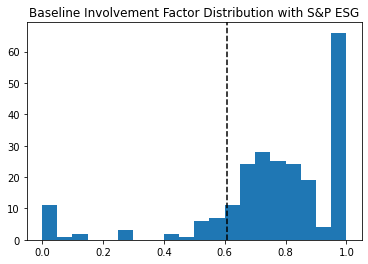

In [13]:
# histogram
plt.hist(inv_factors["inv_factor"], bins=20)
plt.axvline(x=len(sp_esg) / len(sp_500), color="black", linestyle="--")
plt.title("Baseline Involvement Factor Distribution with S&P ESG");